In [1]:
import numpy as np
import umap
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
import bokeh.plotting as bp
import segypy
from scipy.interpolate import interp2d
%load_ext autoreload
%autoreload 2
from utils import load_seismic, load_horizon, colorbar, interpolate_horizon, plot_section_horizon_and_well
from utils import flatten_on_horizon

## Loading the seismic near and far offset amplitude data from the segy files

Here we load the seismic data from the data provided by Per's book.  
Had to resort to segypy to load the data as segyio didn't manage to load the data out of the box.

In [2]:
near_stack_amplitudes, twt = load_seismic('./data/3d_nearstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])
far_stack_amplitudes, twt = load_seismic('./data/3d_farstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])

SegyPY0.57:  readSegy : Trying to read ./data/3d_nearstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_nearstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data
SegyPY0.57:  readSegy : Trying to read ./data/3d_farstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_farstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data


## Loading and interpolating the picked horizon data

We load the picked horizon from the provided text file.  
The data is not interpreted on every inline so we have to interpolate.  

In [3]:
horizon = load_horizon('./data/Top_Heimdal_subset.txt', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])

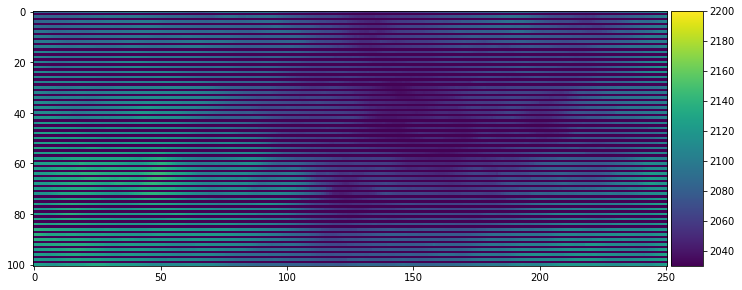

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax1 = ax.imshow(horizon, vmin=2030, vmax=2200)
colorbar(ax1)

This helper function does 2D linear interpolation of the horizon data.  

In [5]:
interpolated_horizon = interpolate_horizon(horizon)

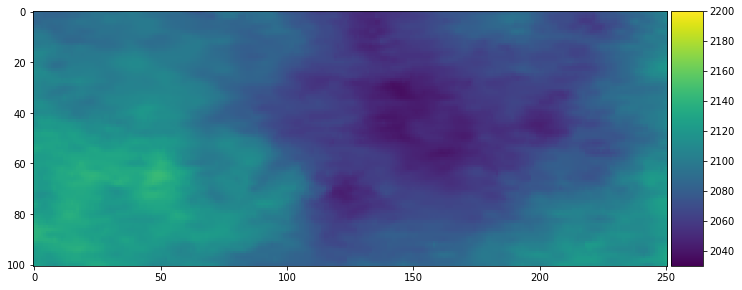

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax1 = ax.imshow(interpolated_horizon, vmin=2030, vmax=2200)
colorbar(ax1)

## Plotting the amplitude data with the horizon and the well as in Per's Book

We have determined the position of the well translating frovm inline-crossline ranges (il: 1300-1502, xl: 1500-2002) to local numpy array indices of x, y position.

In [7]:
well_i, well_x = 36, 276//2

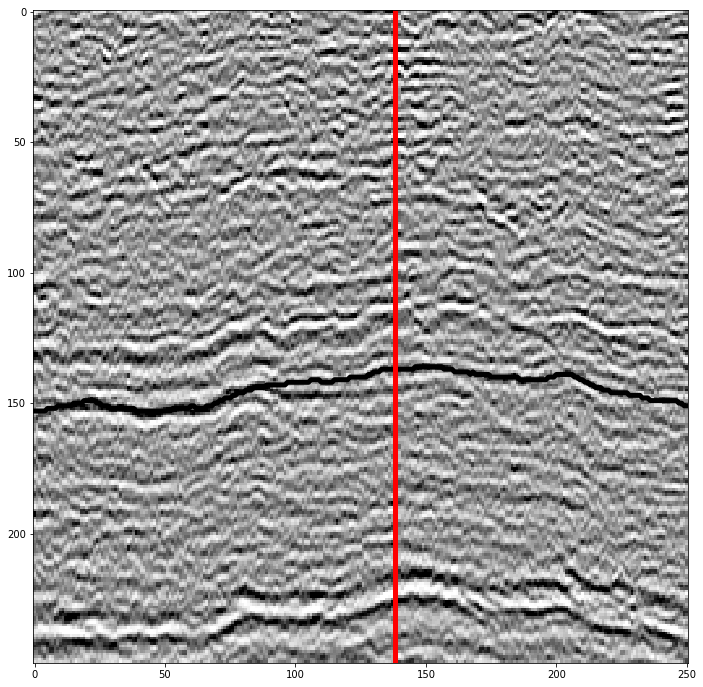

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_section_horizon_and_well(ax, near_stack_amplitudes, horizon, twt, inline=well_i, well_pos=well_x)

## Flatten the traces on the horizon and select 64 samples around the horizon

We flatten the traces by determining the closest sample to the picked horizon and then going 12 samples up and 52 samples down. These 64 samples are then used for further processing. The idea here is that the 64 samples cover the whole span of the reservoir interval.

In [9]:
near_traces = flatten_on_horizon(near_stack_amplitudes, horizon, twt, top_add=12, below_add=52)
far_traces = flatten_on_horizon(far_stack_amplitudes, horizon, twt, top_add=12, below_add=52)

Plotting the flattened traces and the position of the picked horizon.  

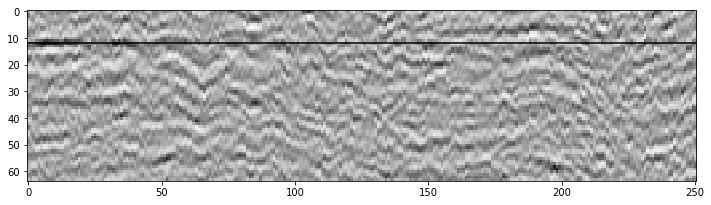

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(near_traces[0].T, cmap="Greys")
ax.axhline(12, color="black")

If you're running this notebook fresh you can save the near and far traces so that you don't have to process everything from scratch again.

In [14]:
#np.save("near_traces_64.npy", near_traces)
#np.save("far_traces_64.npy", far_traces)

## Unsupervised Cluster Analysis of Glitne Near-Far Offset Data and Fluid Factor

The aim of this notebook is to analyse the Glitne Near-Far Offset Data using unsupervised dimensionality reduction methods and to evaluate the presence of clusters within the data.  
These clusters may be linked to the present hydrocarbon anomaly in the Glitne dataset.

### Data Loading

We've already previously converted the near and far offset traces from segy to a numpy array for easier handling of the data. The data shown has been flattened on the horizon of the heimdahl.

The well position of well-15-5 is 38/138 in this frame of reference.

We normalize the whole dataset using a 3x3 grid around the well.  
Near and Far offset data are normalised seperately.

In [15]:
near_traces = np.load("./near_traces_64.npy")
far_traces =  np.load("./far_traces_64.npy")

well_i, well_x = 38, 138

well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))

near_traces /= well_variance_near
far_traces /= well_variance_far

near_traces_emb = near_traces.reshape(-1, 64)
far_traces_emb = far_traces.reshape(-1, 64)

### Plotting the normalised near and far offset traces respectively

Text(0.5, 1.0, 'Far')

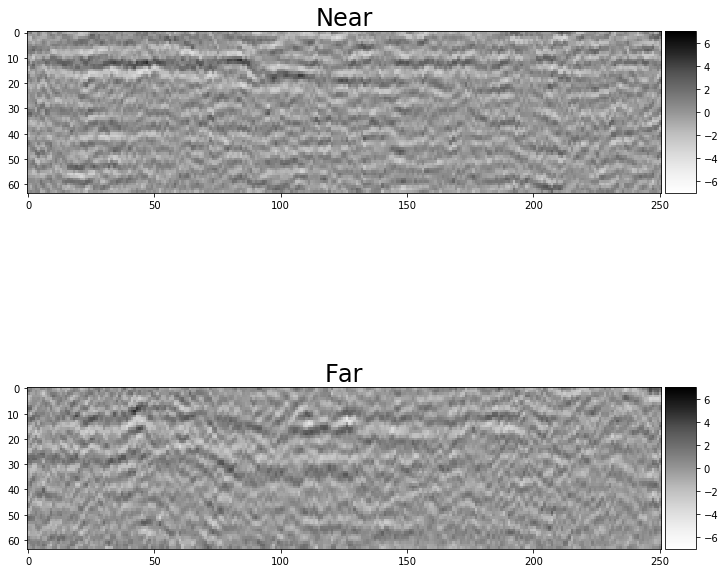

In [16]:
#I changed this graph to plot through the well line 38 rather than line 32 as was in the original
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax1 = ax[0].imshow(near_traces[well_i].T, cmap="Greys", vmin=-7, vmax=7)
colorbar(ax1)
ax2 = ax[1].imshow(far_traces[well_i].T, cmap="Greys", vmin=-7, vmax=7)
colorbar(ax2)
ax[0].set_title("Near", fontsize=24)
ax[1].set_title("Far", fontsize=24)

### Stacking the near and far offset data

The unsupervised dimensionality reduction method we will use, UMAP, treats each sample within a trace, near or far offset, as an independent variable. Therefore we simply concatenate the two traces to a stacked trace.  
Not to confuse this with _seismic stacking_, the first 64 variables will correspond to the 64 samples of our far offset trace, the second set of 64 variables will correspond to the 64 samples of the near offset trace.  

In [17]:
stacked = np.concatenate([far_traces_emb, near_traces_emb], 1)
print(stacked.shape)

(25351, 128)


### Computing a crude approximation to the fluid factor

We will use here a crude approximation to the fluid factor by computing

$$y_{avo} = \alpha*x_{avo}$$
$$f_{fluid} = y_{avo}-\alpha*x_{avo}$$

where 
- $x_{avo}$ corresponds to a near offset sample amplitude
- $y_{avo}$ corresponds to the difference between the far offset sample amplitude and the near offset amplitude

Hence the fluid factor $f_{fluid}$ is a per sample property and we can later plot it for each of our datapoints.

In [18]:
x_avo = near_traces_emb
y_avo = far_traces_emb-near_traces_emb

### Performing a linear regression on $y_{avo}$ and $x_{avo}$

We use sckit-learns linear regression to fit the above equation.  

In [19]:
lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
lin_reg.fit(x_avo.reshape(-1, 1), y_avo.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

### Plotting the regression line and every 100th data point within the whole dataset

Since the data are so massive I resort to using [Datashader](http://datashader.org/index.html) to plot the per/sample data.

In [20]:
df = pd.DataFrame.from_items([('x', x_avo.flatten()), ('y',  y_avo.flatten())])
line_df = pd.DataFrame.from_items([('x', np.linspace(-10, 10, 100).flatten()), ('y', np.linspace(-10, 10, 100).flatten()*lin_reg.coef_[0, 0])])
line_df.head()
def image_callback(x_range, y_range, w, h, name=None):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count())
    img = tf.shade(agg)
    return tf.dynspread(img, threshold=0.50, name=name)

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(-7, 7), y_range=(-7, 7), plot_width=500, plot_height=500)
p.line(x='x', y='y',source=line_df, color='black',line_color=None)
InteractiveImage(p, image_callback)

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  if __name__ == '__main__':
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  from ipykernel import kernelapp as app


Loading BokehJS ...

### Computing the fluid factor as described above

We compute a "_Fluid Factor_" which is an approximation to the true gradient-intercept analysis done in AVO.  
The more strongly negative this value is the more likely fluid saturation changes to have occured.

In [24]:
print("Linear Regression coefficient: %1.2f" % lin_reg.coef_[0, 0])
FF = y_avo-lin_reg.coef_*x_avo

Linear Regression coefficient: -0.90


### Plotting every amplitude sample and it's corresponding fluid factor value

Strong negative values should be indicative of hydrocarbon presence (fluid modification)

In [25]:
df = pd.DataFrame.from_items([('x', x_avo.flatten()), ('y',  y_avo.flatten()), ('FF', FF.flatten())])
line_df = pd.DataFrame.from_items([('x', np.linspace(-10, 10, 100).flatten()), ('y', np.linspace(-10, 10, 100).flatten()*lin_reg.coef_[0, 0])])
line_df.head()
def image_callback(x_range, y_range, w, h, name=None):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.min('FF'))
    img = tf.shade(agg)
    return tf.dynspread(img, threshold=0.50, name=name)

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(-7, 7), y_range=(-7, 7), plot_width=500, plot_height=500)
p.line(x='x', y='y',source=line_df, color='black',line_color=None)
InteractiveImage(p, image_callback)

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  if __name__ == '__main__':
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  from ipykernel import kernelapp as app


Loading BokehJS ...

### Plotting the fluid factor in reservoir top down view

We see here an anomaly in the fluid factor that may correspond to the features observed in the real field 
and in the case study presented in Per's book. 
<img src="./fig1.jpg" alt="Drawing" style="width: 400px;"/>

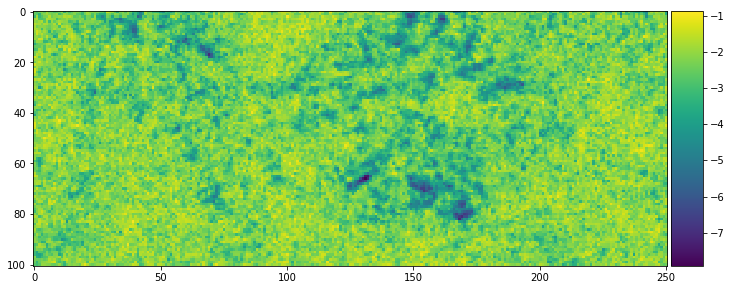

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.imshow(np.min(FF.reshape(near_traces.shape[0], near_traces.shape[1], 64)[:, :, :], 2))
colorbar(sc)

### Performing dimensionality reduction using UMAP

We use the UMAP algorithm ([arXiv-paper](https://arxiv.org/abs/1802.03426)) to perform dimensionality reduction on the stacked near and far offset traces. Each datapoint that is reduced in dimensionality will be represented as a 2-D plane. 

Therefore we perform a mapping of:
$$\mathbf{R}^{128}\Rightarrow\mathbf{R}^2$$

From the description of UMAP on their github repo:

"Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data  

- The data is uniformly distributed on a Riemannian manifold;
- The Riemannian metric is locally constant (or can be approximated as such);
- The manifold is locally connected.  


From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure."

In [34]:
embedding_stack_ff = umap.UMAP(n_neighbors=50,
                      min_dist=0.001,
                      metric='correlation', 
                               verbose=True,
                              random_state=42).fit_transform(np.concatenate([stacked, FF.reshape(-1, 64)], 1))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


### Plotting the dimensionality reduced data and the minimum fluid factor

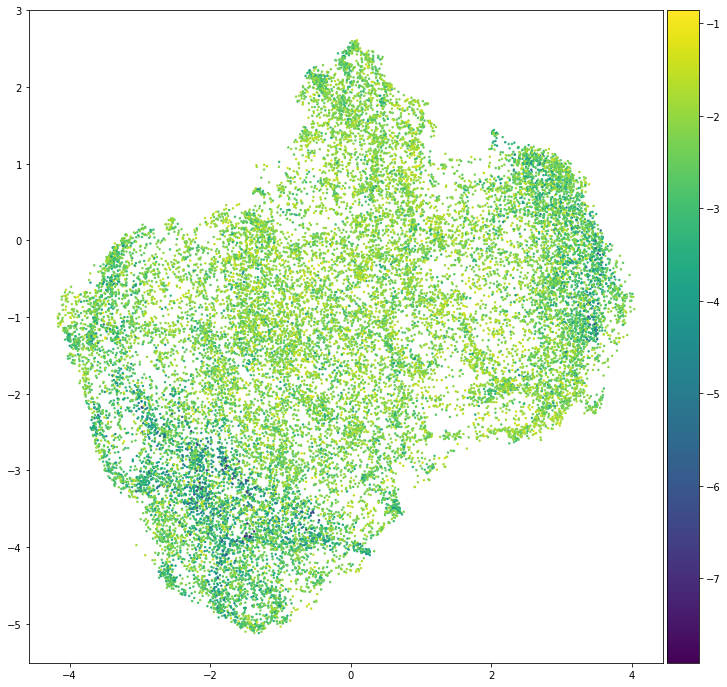

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(embedding_stack_ff[::, 0], embedding_stack_ff[::, 1], s=2.0, c=np.min(FF, 1)[::])
colorbar(sc)

### Clustering of dimensionality reduced data

Here we perform a manual clustering of the data by choosing a part of the 2D data domain where we have found very low fluid factors to cluster together.  

We select this data as a binary indicator and call this our _reservoir indicator_.

The bounds we use here are:
$$ y_{umap} < -2$$
$$ x_{umap} < 0.5$$

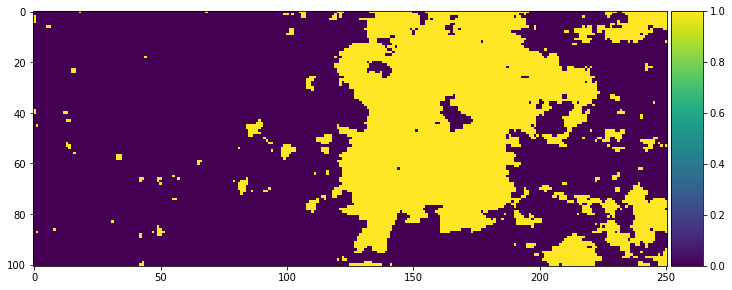

In [36]:
res_indicator = np.zeros((25351, 1))
res_indicator[np.where((embedding_stack_ff[:, 1]<-2) & (embedding_stack_ff[:, 0]<0.5))] = 1
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax1 = ax.imshow(res_indicator.reshape(near_traces.shape[0], near_traces.shape[1]))
colorbar(ax1)

### Plotting the reservoir indicator and the horizon as contour lines

The following graphs were ultimately output for the presentation and used to represent the presence of the avo anomaly by taking into consideration the traditional fluid factor calculation.  

We can observe that the clustered anomaly seems to correspond well with the structural high, possibly delineating the _oil water contact_

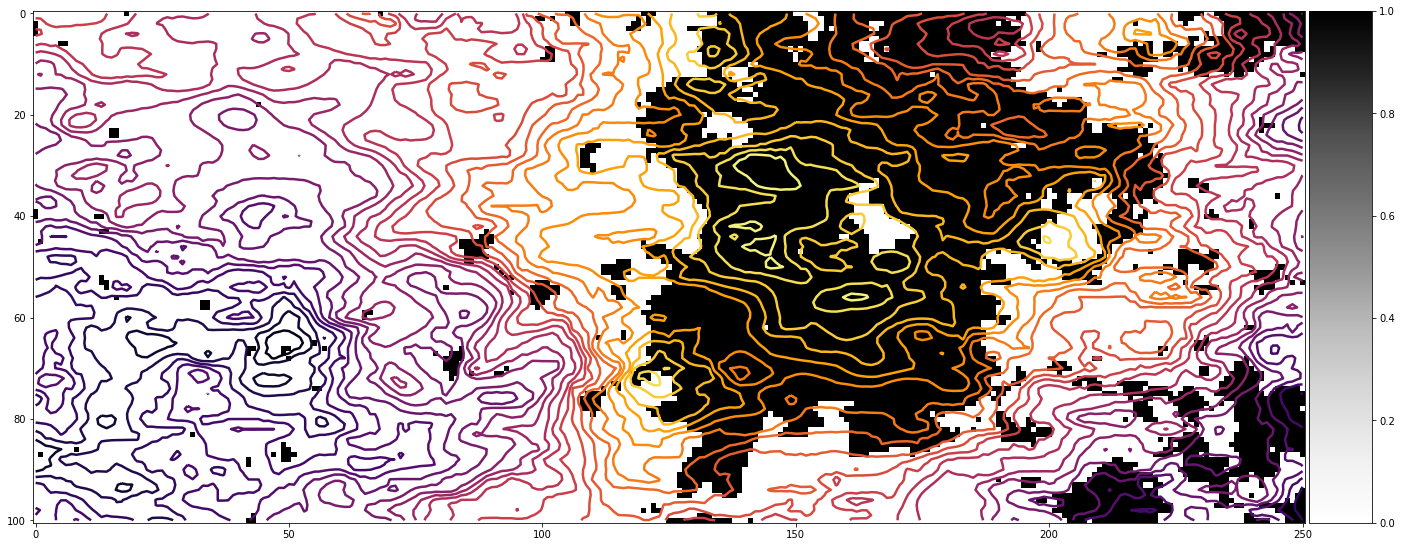

In [37]:
X, Y = np.meshgrid(np.arange(0, interpolated_horizon.shape[1]), np.arange(0, interpolated_horizon.shape[0]))

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
c1 = ax.contour(X, Y, interpolated_horizon, alpha=1.0, levels=np.linspace(interpolated_horizon.min(), interpolated_horizon.max(), 25), linewidths=2.5, cmap="inferno_r")
sc = ax.imshow(res_indicator.reshape(near_traces.shape[0], near_traces.shape[1]), cmap="Greys")
colorbar(sc)

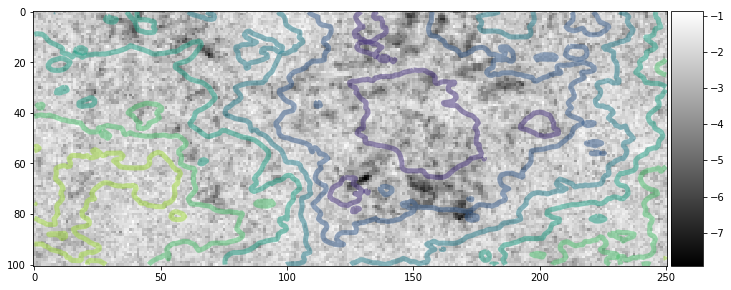

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.imshow(np.min(FF.reshape(near_traces.shape[0], near_traces.shape[1], 64)[:, :, :], 2), cmap="gray")
c1 = ax.contour(X, Y, horizon, alpha=0.5, levels=np.linspace(interpolated_horizon.min(), interpolated_horizon.max(), 8), linewidths=5)
colorbar(sc)

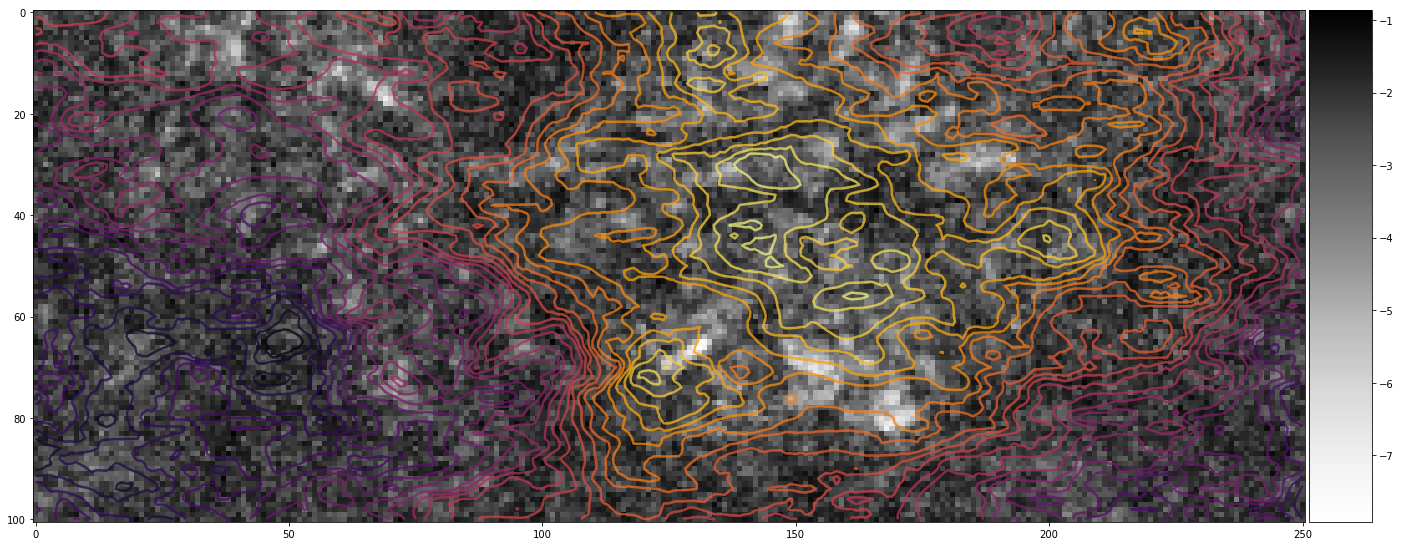

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
c1 = ax.contour(X, Y, interpolated_horizon, alpha=0.75, levels=np.linspace(interpolated_horizon.min(), interpolated_horizon.max(), 25), linewidths=2.5, cmap="inferno_r")
sc = ax.imshow(np.min(FF.reshape(near_traces.shape[0], near_traces.shape[1], 64)[:, :, :], 2), cmap="Greys")
colorbar(sc)

## Applying a Variational Autoencoder to the Glitne Data

In [42]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset
import numpy as np
from sklearn.model_selection import ShuffleSplit

from utils import VAE, set_seed
import os
from livelossplot import PlotLosses

## Hyperparamters

Here we use a batch size of 32, the total window size is 64 (number of samples per trace) and the size of 
the latent variables is 2 for ease of visualization. 

In [57]:
cuda = True
batch_size = 32
window_size = 64
epochs = 100
hidden_size = 8

## Data Loading and Normalization

In [104]:
#Load the traces
near_traces = np.load("./near_traces_64.npy")
far_traces =  np.load("./far_traces_64.npy")

#Normalize by the well neighborhood
well_i, well_x = 38, 138
well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
near_traces /= well_variance_near
far_traces /= well_variance_far

#Sanity Check
print(near_traces.min(), near_traces.max(), near_traces.mean(), near_traces.std())
print(far_traces.min(), far_traces.max(), far_traces.mean(), far_traces.std())

#Reshape the traces
near_traces_emb = near_traces.reshape(-1, 64)
far_traces_emb =far_traces.reshape(-1, 64)

#Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
X = torch.from_numpy(np.stack([near_traces_emb, far_traces_emb], 1)).float()
y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

#We do an 20, 80 split in this case, fairly large since there are so many traces to learn from
#Should also try a different split of say 80, 20
split = ShuffleSplit(n_splits=1, test_size=0.8)
for train_index, test_index in split.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

train_dset = TensorDataset(X_train, y_train)
test_dset = TensorDataset(X_test, y_test)
all_dset = TensorDataset(X, y)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=False, **kwargs)
all_loader = torch.utils.data.DataLoader(all_dset, batch_size=batch_size, shuffle=False, **kwargs)

-5.895588494848423 6.0386670251870616 0.005128109574406768 1.040439154417811
-7.854934933402996 6.753585219701001 0.011143455976573461 1.0586577885410202


## Variational Autoencoder Loss Function

This includes the reconstruction loss and the Kulback-Leibler divergence on the latent variables.  
In total this corresponds to the Evidence Lower BOund (ELBO)

In [105]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, window_size=64):
    criterion_mse = nn.MSELoss(size_average=False)
    MSE = criterion_mse(recon_x.view(-1, 2, window_size), x.view(-1, 2, window_size))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

## Training and evaluation helper functions

In [126]:
#Function to perform one epoch of training
def train(epoch, model, optimizer, train_loader, cuda=False, log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        
        if cuda:
            data = data.cuda()
            
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()*data.size(0)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()*data.size(0) / len(train_loader.dataset)))

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

#Function to perform evaluation of data on the model, used for testing
def test(epoch, model, test_loader, cuda=False, log_interval=10):
    model.eval()
    test_loss = 0
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(test_loader):
                if cuda:
                    data = data.cuda()
                data = Variable(data)
                recon_batch, mu, logvar, _ = model(data)
                test_loss += loss_function(recon_batch, data, mu, logvar).item()*data.size(0)

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

#Function to forward_propagate a set of tensors and receive back latent variables and reconstructions
def forward_all(model, all_loader, cuda=False):
    model.eval()
    reconstructions, latents = [], []
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(all_loader):
                if cuda:
                    data = data.cuda()
                data = Variable(data)
                recon_batch, mu, logvar, z = model(data)
                reconstructions.append(recon_batch.cpu())
                latents.append(z.cpu())
    return torch.cat(reconstructions, 0), torch.cat(latents, 0)

## Training Loop for the VAE Model

In [136]:
from utils import VAE #import the model
set_seed(42) #Set the random seed

model = VAE(hidden_size=8) #Inititalize the model

#use cuda if chosen
if cuda:
    model.cuda()
    
#Create a gradient descent optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))

#Store and plot losses
losses = []
liveloss = PlotLosses()
min_loss = 999999.

#Start training loop
for epoch in range(1, epochs + 1):
    logs = {}
    tl = train(epoch, model, optimizer, train_loader, cuda=cuda) #Train model on train dataset
    logs['' + 'log loss'] = tl
    
    testl = test(epoch, model, test_loader, cuda=cuda) #Validate model on test dataset
    logs['val_' + 'log loss'] = testl
    
    losses.append([tl, testl])
    
    #Update the lossplot
    liveloss.update(logs)
    liveloss.draw()
    
    #Store best validation loss model
    if testl < min_loss:
        torch.save(model.state_dict(), "./models/model_epoch_"+str(epoch)+".pth")
        min_loss = testl
        
    break

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/5070 (0%)]	Loss: 30.633956
Train Epoch: 1 [320/5070 (6%)]	Loss: 28.457945
Train Epoch: 1 [640/5070 (13%)]	Loss: 28.454768
Train Epoch: 1 [960/5070 (19%)]	Loss: 27.742573
Train Epoch: 1 [1280/5070 (25%)]	Loss: 28.371795
Train Epoch: 1 [1600/5070 (31%)]	Loss: 27.301883
Train Epoch: 1 [1920/5070 (38%)]	Loss: 26.349464
Train Epoch: 1 [2240/5070 (44%)]	Loss: 25.458349
Train Epoch: 1 [2560/5070 (50%)]	Loss: 27.350737
Train Epoch: 1 [2880/5070 (57%)]	Loss: 26.704453
Train Epoch: 1 [3200/5070 (63%)]	Loss: 26.153199


KeyboardInterrupt: 

## Load Model and get all latents and reconstructions on the whole cube

In [107]:
model.load_state_dict(torch.load("./models/model_epoch_56.pth"))

In [108]:
rec, zs = forward_all(model, all_loader, cuda=cuda)

In [109]:
print(rec.size(), zs.size())

torch.Size([25351, 2, 64]) torch.Size([25351, 8])


## Plot a side view of the reconstructed data, near and far offset


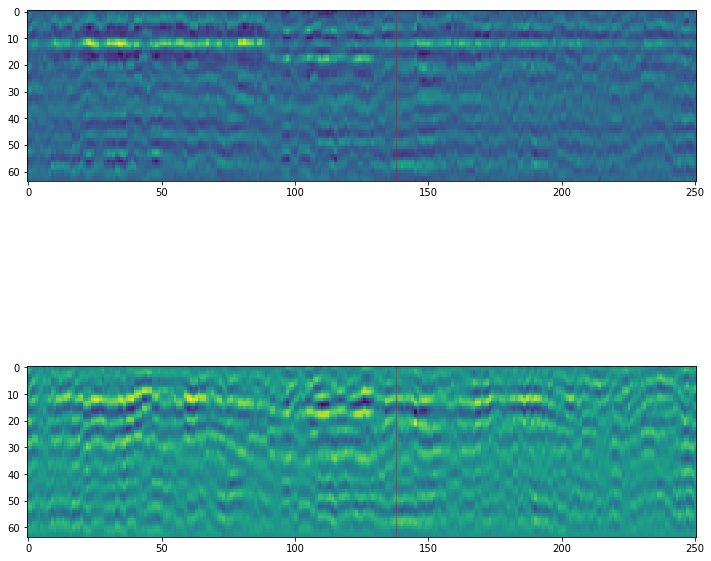

In [110]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].imshow(rec.reshape(101, 251, 2, 64)[38, :, 0, :].numpy().T)
ax[1].imshow(rec.reshape(101, 251, 2, 64)[38, :, 1, :].numpy().T)
ax[0].axvline(138, color="red", alpha=0.5, linewidth=1)
ax[1].axvline(138, color="red", alpha=0.5, linewidth=1)

In [111]:
near_sampled = rec.reshape(101, 251, 2, 64)[:, :, 0, :].numpy()
far_sampled = rec.reshape(101, 251, 2, 64)[:, :, 1, :].numpy()

Text(0.5, 1.0, 'Far Offset')

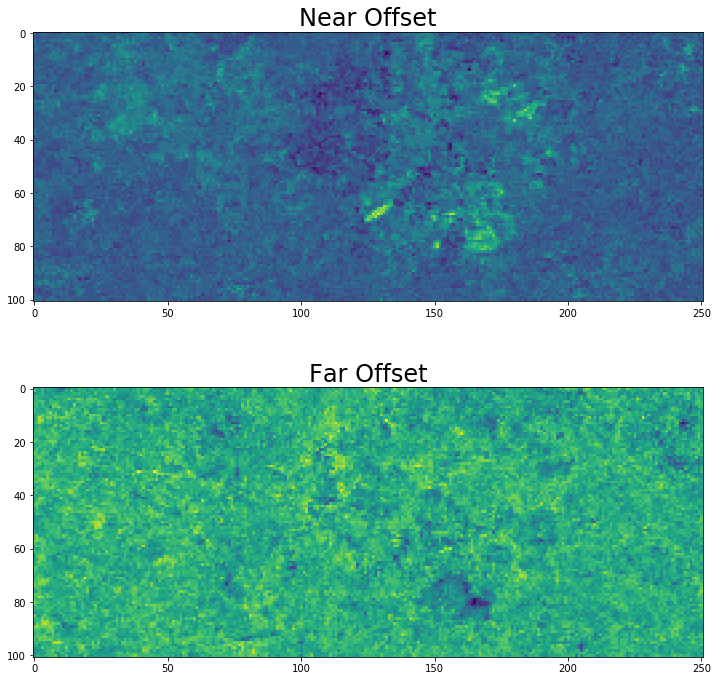

In [112]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].imshow(np.mean(near_sampled, 2))
sc = ax[1].imshow(np.mean(far_sampled, 2))
ax[0].set_title("Near Offset", fontsize=24)
ax[1].set_title("Far Offset", fontsize=24)

 ## Plot the near and far offset traces in map view

Text(0.5, 1.0, 'Far Offset')

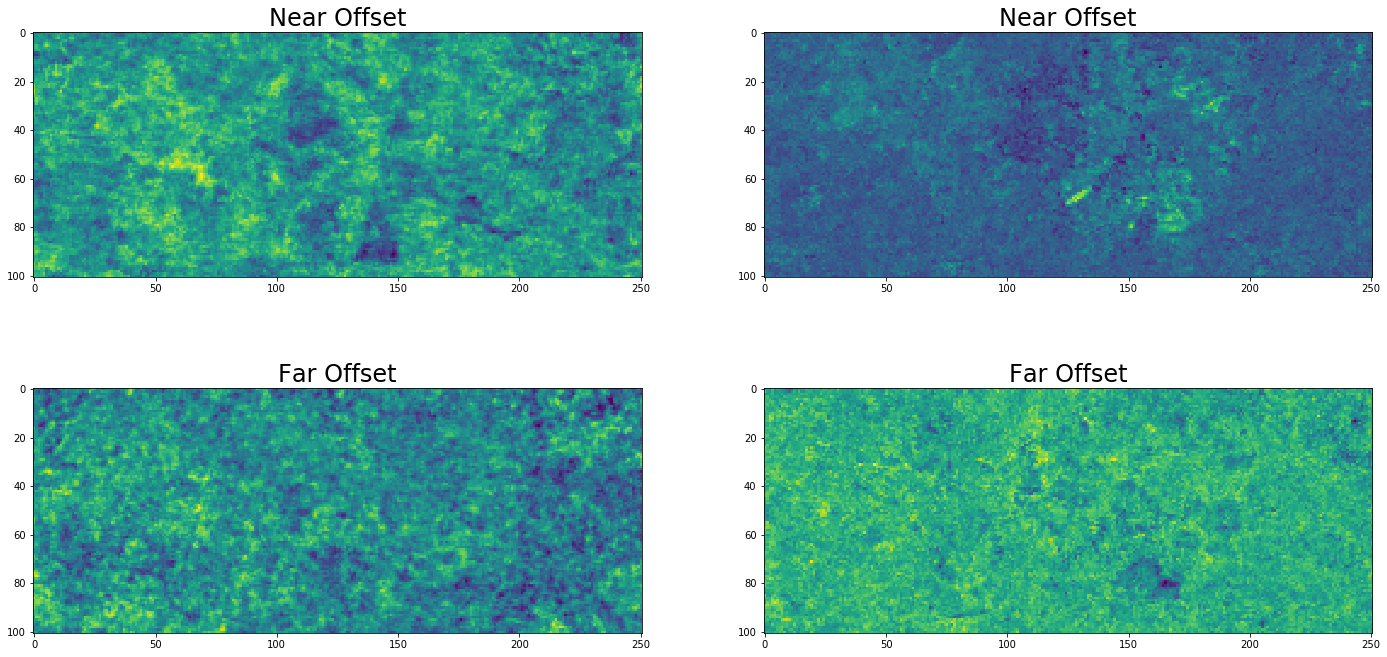

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12))
ax[0, 1].imshow(np.mean(near_sampled, 2))#, vmin=vmin, vmax=vmax)
sc = ax[1, 1].imshow(np.mean(far_sampled, 2))#, vmin=vmin, vmax=vmax)
ax[0, 1].set_title("Near Offset", fontsize=24)
ax[1, 1].set_title("Far Offset", fontsize=24)

ax[0, 0].imshow(np.mean(near_traces, 2))#, vmin=vmin, vmax=vmax)
sc = ax[1, 0].imshow(np.mean(far_traces, 2))#, vmin=vmin, vmax=vmax)
ax[0, 0].set_title("Near Offset", fontsize=24)
ax[1, 0].set_title("Far Offset", fontsize=24)

## Visualize the 8-dimensional latent space by projecting using umap

In [115]:
transformer = umap.UMAP(n_neighbors=5,
                      min_dist=0.001,
                      metric='correlation', verbose=True).fit(zs.numpy())
embedding = transformer.transform(zs.numpy())

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
   n_neighbors=5, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


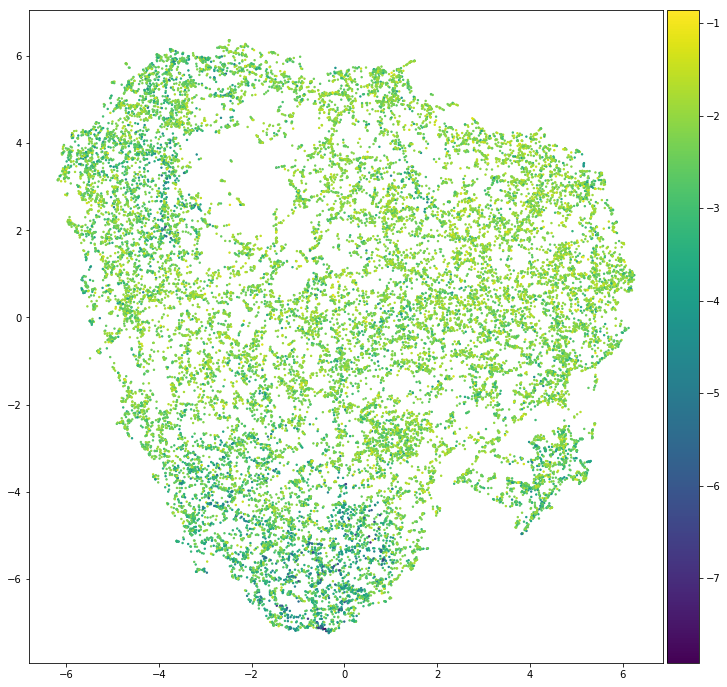

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(embedding[::, 0], embedding[::, 1], s=2.0, c=np.min(FF, 1)[::])
colorbar(sc)

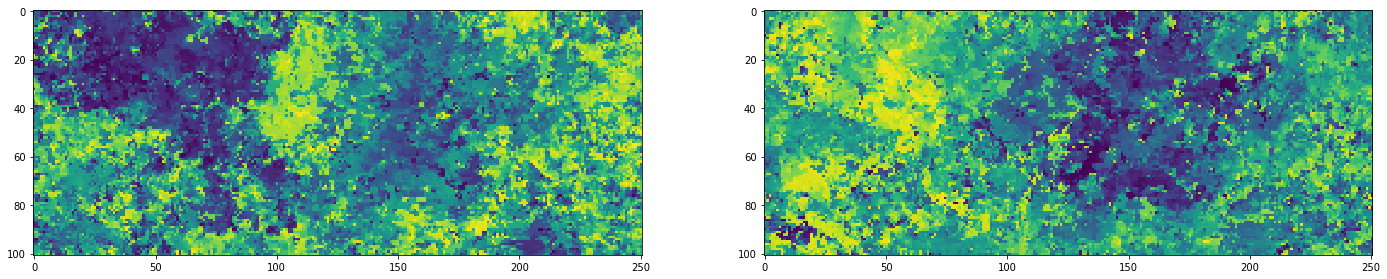

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(24, 24))
ax[0].imshow(embedding[:, 0].reshape(101, 251))
ax[1].imshow(embedding[:, 1].reshape(101, 251))

## Importing the synthetics created at the hackathon

In [127]:
synthetics = pd.read_csv("./megasynt.csv")
synthetics['WELL']=synthetics['WELL'].astype('category')
synthetics['ID']=synthetics['ID'].astype('category')
synthetics.head()

TWT        DEPTH           VP           VS       RHO          NEAR  \
0  2.568  2100.822816  2429.415852  1018.341144  2.255582 -1.215363e-10   
1  2.572  2105.563679  2429.415852  1018.341144  2.255582 -3.881229e-09   
2  2.576  2110.183740  2429.415852  1018.341144  2.255582 -9.194981e-08   
3  2.580  2114.912341  2429.415852  1018.341144  2.255582 -1.611343e-06   
4  2.584  2119.814871  2429.415852  1018.341144  2.255582 -2.080550e-05   

            FAR    WELL               ID  
0 -8.058615e-11  W155_5  Z40_Sw025_Por20  
1 -2.573498e-09  W155_5  Z40_Sw025_Por20  
2 -6.096849e-08  W155_5  Z40_Sw025_Por20  
3 -1.068421e-06  W155_5  Z40_Sw025_Por20  
4 -1.379535e-05  W155_5  Z40_Sw025_Por20

In [135]:
unique_names = np.unique(synthetics['ID'])

z_vals, sw_vals, por_vals = [], [], []
for max_cor in unique_names:
    splt = max_cor.split("_")
    z_val = float(splt[0][1:])
    sw_val = float(splt[1].strip("Sw"))
    por_val = float(splt[2][3:])
    z_vals.append(z_val)
    sw_vals.append(sw_val)
    por_vals.append(por_val)

In [129]:
synthetics_well = []
for name in unique_names:
    well = synthetics.loc[synthetics['ID'] == name]
    synthetics_well.append([well['NEAR'], well['FAR']])
synthetics_well = np.array(synthetics_well)

## Create a dataset of the pseudo-well synthetics to put through the VAE

In [130]:
pseudos = synthetics_well

well_i, well_x = 38, 138
well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))

well_trace_near = near_traces[well_i, well_x]
well_trace_far = far_traces[well_i, well_x]

well_trace_near_abs_std = np.std(np.abs(well_trace_near))
well_trace_far_abs_std = np.std(np.abs(well_trace_far))

print("1", well_trace_near_abs_std/pseudos[:, 0, :].std(), well_variance_near)
print("2", well_trace_far_abs_std/pseudos[:, 1, :].std(), well_variance_far)

pseudos[:, 0, :] = pseudos[:, 0, :]*well_trace_near_abs_std/ pseudos[:, 0, :].std()
pseudos[:, 1, :] = pseudos[:, 1, :]*well_trace_far_abs_std/pseudos[:, 1, :].std()

near_traces /= well_variance_near
far_traces /= well_variance_far

pseudos[:, 0, :] /= well_variance_near
pseudos[:, 1, :] /= well_variance_far

amplitude_factor = 3.
X = torch.from_numpy(np.stack([pseudos[:, 0, :], pseudos[:, 1, :]], 1)).float()*amplitude_factor
y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

pseudo_dset = TensorDataset(X, y)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

pseudo_loader = torch.utils.data.DataLoader(pseudo_dset, batch_size=batch_size, shuffle=False, **kwargs)

1 18.02221929967681 1.0
2 24.103460516196403 1.0


## Get the latent variables for the pseudo-wells

In [131]:
recs_pseudo, zs_pseudo = forward_all(model, pseudo_loader, cuda=cuda)

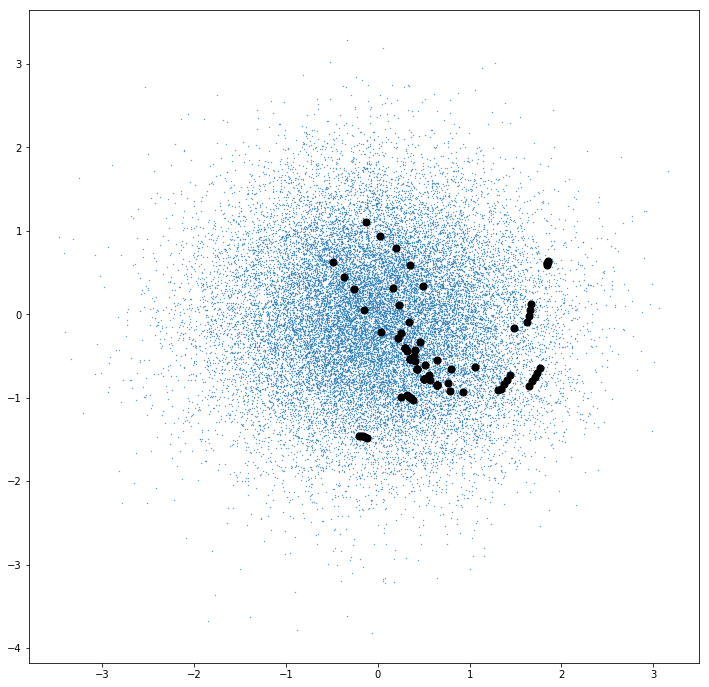

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(zs[:, 0], zs[:, 1], s=0.1)
ax.scatter(zs_pseudo[:, 0], zs_pseudo[:, 1], s=50, color="black")
#fig.savefig("unsupervised_encoder_space_with_superstack.png", dpi=300, bbox_inches="tight")

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


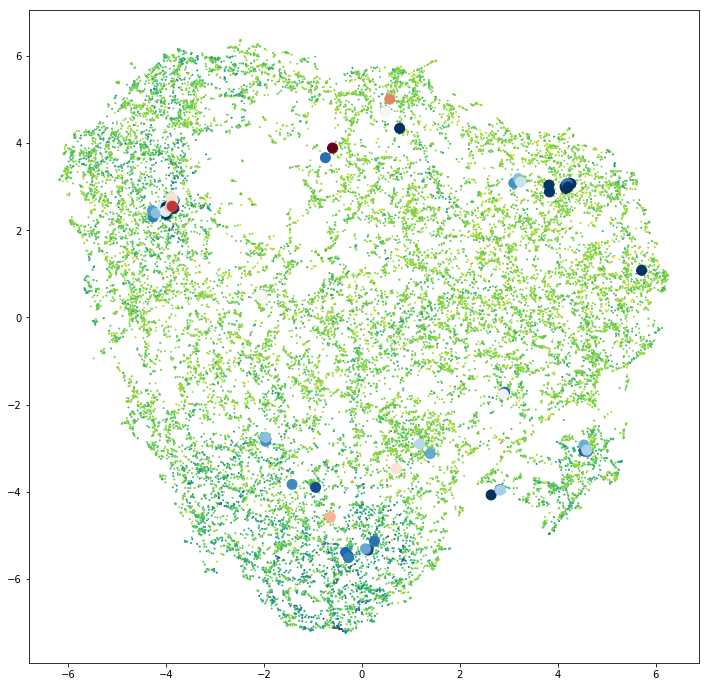

In [133]:
pseudo_umap = transformer.transform(zs_pseudo.numpy())
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(embedding[:, 0], embedding[:, 1], s=1.0, c=np.min(FF, 1))
ax.scatter(pseudo_umap[:, 0], pseudo_umap[:, 1], s=100.0, c=np.array(z_vals)*np.array(por_vals)*(1.-np.array(sw_vals)), cmap="RdBu")